In [1]:
import numpy as np
import pandas as pd
import csv
import struct
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow import keras
import statistics

In [2]:
# reading and additional functions

# define moving average function
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

# check exist date in roti date array
def exist_date_roti(roti_date, date_check):
    for date_r in roti_date:
        if date_check[0] == date_r[0] and date_check[1] == date_r[1] and date_check[2] == date_r[2]:
            return True
    return False

# convert doy in normal date with day and month
def doy2day(doy, year):
    startDate = datetime(year=year, month=1, day=1)
    daysToShift = doy - 1
    endDate = startDate + timedelta(days=daysToShift)
    
    month = endDate.month
    day = endDate.day
    
    return day, month

def read_roti(filename):
    with open(filename, 'rb') as f:
        header_read = False
        date = None
        lats = []
        rows = []
        date_arr = []
        line = f.readline()
        while not header_read or (line.strip() and not line.strip().startswith(b"END OF ROTIPOLARMAP")):
            if line.strip().startswith(b"START OF ROTIPOLARMAP"):
                header_read = True
            elif line.strip().startswith(b"END OF ROTIPOLARMAP") or line.strip().startswith(b"END OF FILE"):
                break
            elif not header_read:
                pass
            elif line[0:5].strip():
                date = datetime(int(line[0:7]), int(line[7:14]), int(line[14:21]))
                year = int(line[0:7])
                month = int(line[7:14])
                day = int(line[14:21])
                
                date_arr.append(day)
                date_arr.append(month)
                date_arr.append(year)
            else:
                lat, lon_start, lon_end = float(line[3:9]), float(line[9:15]), float(line[15:21])
                lats.append(lat)

                block = [f.readline() for _ in range(18)]
                row = np.genfromtxt(block)
                rows.append(row.ravel())
            line = f.readline()
        return date, np.array(lats), np.array(date_arr), np.array(rows)

def get_array_roti():
    maps = []
    map_date = []
    for year in range(10, 21, 1):
        for doy in range(1, 367, 1):
            if doy > 295 and year == 20:
                break
            daily_lats = []
            daily_date = []
            daily_map = []
            
            if len(str(doy)) == 1:
                doy_str = "00" + str(doy)
            elif len(str(doy)) == 2:
                doy_str = "0" + str(doy)
            else:
                doy_str = str(doy)
            filename = '../data/roti/2010-2020/roti' + doy_str + '0.' + str(year) + 'f'
            try:
                date, daily_lats, daily_date, daily_map = read_roti(filename)
            except FileNotFoundError:
                continue
            else:
                date, daily_lats, daily_date, daily_map = read_roti(filename)

            map_date.append(daily_date)
            maps.append(daily_map)

    return np.array(map_date), np.array(maps)

def read_dst(filename, roti_date):
    with open(filename, 'r') as f:
        dst_arr = []
        dst_mean_arr = []
        dst_date = []

        day = 0
        month = 0
        year = 0

        while day != 21 or month != 10 or year != 2020:
            dst_daily = []
            date = []

            line = f.readline()

            year = int(2000 + int(line[3:5]))
            month = int(line[5:7])
            day = int(line[8:10])
                
            date.append(day)
            date.append(month)
            date.append(year)
            
            if not exist_date_roti(roti_date, date):
                continue

            dst_date.append(date)

            if len(line) > 121:
                index_string = line[21:len(line)]
            else:
                index_string = line[21:120]

            index_value = index_string.split()
            for value in index_value:
                val = float(value)
                dst_daily.append(val)

            dst_mean = dst_daily[-1]
            dst_daily.pop(-1)
            dst_arr.append(dst_daily)
            dst_mean_arr.append(dst_mean)
        
        return np.array(dst_arr), np.array(dst_date), np.array(dst_mean_arr)

def add_special_date_f107(day, month, year, f107_arr, f107_date):
    f107_daily = []
    date = []
    if year == 2011:
        value = 90.1
    elif year == 2012:
        value = 131.75
    elif year == 2015:
        value = 148.8
    elif year == 2020:
        value = 72.93
    f107_daily.append(value)
    f107_arr.append(f107_daily)
    date.append(day)
    date.append(month)
    date.append(year)
    f107_date.append(date)
    return f107_arr, f107_date

def read_f107(filename, roti_date):
    with open(filename, 'rb') as f:
        f107_arr = []
        f107_date = []
        day = 0
        month = 0
        year = 0
        
        # we should skip 2 lines in file bc it is head of file
        line = f.readline()
        line = f.readline()

        start_indx = 0
        sum_siblings = 0
        f107_obs_sum = 0

        while day != 22 or month != 10 or year != 2020:
            f107_daily = []
            date = []
            
            line = f.readline()
            
            year = int(line[0:4])
            month = int(line[4:6])
            day = int(line[6:8])
            
            if year < 2010:
                continue
            
            date.append(day)
            date.append(month)
            date.append(year)

            if not exist_date_roti(roti_date, date):
                continue

            if start_indx == 0:
                start_date = date
                start_indx = 1

            f107_obs = float(line[53:63])

            if start_date[0] != date[0] or start_date[1] != date[1] or start_date[2] != date[2]:
                f107_date.append(start_date)
                if sum_siblings == 1:
                    value = f107_obs_sum / 2
                elif sum_siblings == 2:
                    value = f107_obs_sum / 3
                elif sum_siblings == 3:
                    value = f107_obs_sum / 4
                else:
                    value = f107_obs
                f107_daily.append(value)
                f107_arr.append(f107_daily)
                sum_siblings = 0
                f107_obs_sum = 0
                if start_date[0] == 31 and start_date[1] == 12 and start_date[2] == 2010:
                    f107_arr, f107_date = add_special_date_f107(1, 1, 2011, f107_arr, f107_date)
                if start_date[0] == 31 and start_date[1] == 12 and start_date[2] == 2011:
                    f107_arr, f107_date = add_special_date_f107(1, 1, 2012, f107_arr, f107_date)
                if start_date[0] == 12 and start_date[1] == 1 and start_date[2] == 2015:
                    f107_arr, f107_date = add_special_date_f107(13, 1, 2015, f107_arr, f107_date)
                if start_date[0] == 20 and start_date[1] == 10 and start_date[2] == 2020:
                    f107_arr, f107_date = add_special_date_f107(21, 10, 2020, f107_arr, f107_date)
                start_date = date
            else:
                f107_obs_sum += f107_obs
                sum_siblings += 1

        return np.array(f107_arr), np.array(f107_date)

def read_bz_sw(filename, roti_date):
    with open(filename, 'rb') as f:
        bz_arr = []
        bz_date = []
        sw_arr = []
        sw_date = []
        
        day = 0
        month = 0
        year = 0
        
        while day != 21 or month != 10 or year != 2020:
            bz_daily = []
            sw_daily = []
            date = []
            
            line = f.readline()
            
            year = int(line[0:4])
            doy = int(line[5:8])
            day, month = doy2day(doy, year)
            
            date.append(day)
            date.append(month)
            date.append(year)

            if not exist_date_roti(roti_date, date):
                continue
            
            bz_sw_string = line[18:len(line)]
            bz_sw_value = bz_sw_string.split()
            
            bz_date.append(date)
            sw_date.append(date)
            
            for i in range(3):
                if i == 0:
                    bz_daily.append(float(bz_sw_value[i].decode()))
                else:
                    sw_daily.append(float(bz_sw_value[i].decode()))
            
            bz_arr.append(bz_daily)
            sw_arr.append(sw_daily)
        
    return np.array(bz_arr), np.array(bz_date), np.array(sw_arr), np.array(sw_date)

def read_kp(filename, roti_date):
    with open(filename, 'rb') as f:
        kp_arr = []
        kp_date = []
        
        day = 0
        month = 0
        year = 0

        # we should skip first line in file bc it is head of file
        line = f.readline()
        
        while day != 21 or month != 10 or year != 2020:
            kp_daily = []
            date = []

            line = f.readline()

            year = int(line[0:4])
            month = int(line[4:6])
            day = int(line[6:8])

            date.append(day)
            date.append(month)
            date.append(year)

            if not exist_date_roti(roti_date, date):
                continue

            kp_date.append(date)

            kp_str = str(line[25:28].decode())
            
            if kp_str[len(kp_str) - 1] == '+':
                kp_value = float(kp_str[:len(kp_str) - 1]) + 1/3
                kp_value = float("{0:.2f}".format(kp_value))
            elif kp_str[len(kp_str) - 1] == '-':
                kp_value = float(kp_str[:len(kp_str) - 1]) - 1/3
                kp_value = float("{0:.2f}".format(kp_value))
            else:
                kp_value = float(kp_str)

            kp_daily.append(kp_value)
            kp_arr.append(kp_daily)
            
        return np.array(kp_arr), np.array(kp_date)


In [3]:
# plotting functions

def plot_data_roti(date, lons, lats, map):
    lons, lats = np.meshgrid(lons, lats)

    fig1 = plt.figure()
    ax = fig1.add_subplot(111, projection='polar')
    levels = np.arange(0, 0.6, 0.1)
    cc = ax.contourf(np.deg2rad(lons), 90. - lats, map, levels=levels, extend='both')

    plt.title("ROTI index date: " + str(date))

    plt.colorbar(cc, ax=ax, label="ROTI, TECU/min")

    mlt = np.linspace(0, 24, 49)

    plt.show()

def plot_sw_index(date, array_data, name_index):
    fig_prot = plt.figure()
    ax_prot = fig_prot.add_subplot(111)

    fig_pls = plt.figure()
    ax_pls = fig_pls.add_subplot(111)

    prot = []
    pls = []

    data_month_prot = []
    data_month_pls = []
    month_line_prot = []
    month_line_pls = []

    if name_index == 'Solar Wind':
        for item in array_data:
            prot.append(item[0])
            pls.append(item[1])

    day_line = np.arange(0, len(date), 1).reshape(len(array_data), 1)

    for i in range(len(array_data)):
        if i % 30 == 0:
            data_month_prot.append(np.mean(prot[i - 30: i]))
            data_month_pls.append(np.mean(pls[i - 30: i]))
            month_line_prot.append(i - 30 / 2)
            month_line_pls.append(i - 30 / 2)

    data_avg_prot = moving_avg(prot, 400)
    data_avg_plasm = moving_avg(pls, 400)
    data_avg_prot.reshape(len(data_avg_prot), 1)
    data_avg_plasm.reshape(len(data_avg_plasm), 1)
    step = len(prot) / len(data_avg_prot)
    day_avg = np.arange(0, len(date), step).reshape(len(data_avg_prot), 1)

    ax_pls.set_title('Data index Plasma Speed, km/s')
    ax_pls.set_xlabel('Days', size=12)
    ax_pls.set_ylabel(name_index, size=12)
    # ax.plot(day_line, array_data, label='Day')
    ax_pls.plot(month_line_pls, data_month_pls, label='Month')
    ax_pls.plot(day_avg, data_avg_plasm, color='red', label='Avg-400')
    # ax.plot(half_year_line, data_half_year, color='black', label='Half-year')
    ax_pls.legend(loc='upper left')

    ax_prot.set_title('Data index Proton Density, N/cm^3')
    ax_prot.set_ylim(0, 20)
    ax_prot.set_xlabel('Days', size=12)
    ax_prot.set_ylabel(name_index, size=12)
    # ax.plot(day_line, array_data, label='Day')
    ax_prot.plot(month_line_prot, data_month_prot, label='Month')
    ax_prot.plot(day_avg, data_avg_prot, color='red', label='Avg-400')
    # ax.plot(half_year_line, data_half_year, color='black', label='Half-year')
    ax_prot.legend(loc='upper left')

    plt.show()

def plot_data_index(date, array_data, name_index):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    data_month = []
    month_line = []

    data_half_year = []
    half_year_line = []

    data_year = []
    year_line = []

    day_line = np.arange(0, len(date), 1).reshape(len(array_data), 1)

    for i in range(len(array_data)):
        if i % 30 == 0:
            data_month.append(np.mean(array_data[i - 30: i]))
            month_line.append(i - 30 / 2)

    for i in range(len(array_data)):
        if i % 180 == 0:
            data_half_year.append(np.mean(array_data[i - 180: i]))
            half_year_line.append(i - 180 / 2)
    
    data_avg = moving_avg(array_data, 400)
    data_avg.reshape(len(data_avg), 1)
    step = len(array_data) / len(data_avg)
    day_avg = np.arange(0, len(date), step).reshape(len(data_avg), 1)

    ax.set_title('Data index ' + name_index)
    ax.set_xlabel('Days', size=12)
    ax.set_ylabel(name_index, size=12)

    match name_index:
        case 'Flux 10-7':
            ax.plot(month_line, data_month, label='Month')
            ax.plot(half_year_line, data_half_year, label='Half-year')
            ax.plot(day_avg, data_avg, color='red', label='Avg-400')
            # ax.plot(year_line, data_year, color='black', label='Year')
            ax.legend(loc='upper left')
        case 'Imf-Bz':
            # ax.plot(day_line, array_data, label='Day')
            ax.plot(month_line, data_month, label='Month')
            ax.plot(day_avg, data_avg, color='red', label='Avg-400')
            # ax.plot(half_year_line, data_half_year, color='black', label='Half-year')
            ax.legend(loc='upper left')
        case _:
            ax.plot(day_line, array_data, label='Day')
            ax.plot(month_line, data_month, label='Month')
            ax.plot(day_avg, data_avg, color='red', label='Avg-400')
            # ax.plot(half_year_line, data_half_year, color='black', label='Half-year')
            ax.legend(loc='upper left')
    plt.show()

In [4]:
# roti data and date
# roti_map_date = []
# roti_maps = []
# roti_map_date, roti_maps = get_array_roti()

filename = "../data/roti/rt_data_10-20.txt"
date, lats, roti_map_date, roti_maps = read_roti_txt(filename)

In [5]:
# data
# kp_data, bz_data, sw_data, f107_data, dst_data

kp_file = '../data/kp/Kp_index.txt'
kp_arr, kp_date = read_kp(kp_file, roti_map_date)

bz_sw_file = '../data/imfbz_sw/omni2_daily_Wxi8tQda3U.lst.txt'
bz_arr, bz_date, sw_arr, sw_date = read_bz_sw(bz_sw_file, roti_map_date)

f107_file = '../data/f10-7/fluxtable.txt'
f107_arr, f107_date = read_f107(f107_file, roti_map_date)

dst_file = '../data/dst/WWW_dstae03359771.dat.txt'
dst_arr, dst_date, dst_mean_arr = read_dst(dst_file, roti_map_date)

In [25]:
# shape of data
print("shape kp data ", kp_arr.shape)
print("shape kp date line ", kp_date.shape)
print("shape bz data ", bz_arr.shape)
print("shape bz date line ", bz_date.shape)
print("shape sw data ", sw_arr.shape)
print("shape sw date line ", sw_date.shape, "\n")
print("shape f10-7 data ", f107_arr.shape)
print("shape f10-7 date line ", f107_date.shape, "\n")
print("shape dst data ", dst_arr.shape)
print("shape dst data mean", dst_mean_arr.shape)
print("shape dst date line ", dst_date.shape, "\n")
roti_maps_reshape = roti_maps.reshape(3935, 3600)
print("shape roti data ", roti_maps.shape)
print("shape roti data reshape", roti_maps_reshape.shape)
print("shape roti date line ", roti_map_date.shape)

shape kp data  (3935, 1)
shape kp date line  (3935, 3)
shape bz data  (3935, 1)
shape bz date line  (3935, 3)
shape sw data  (3935, 2)
shape sw date line  (3935, 3) 

shape f10-7 data  (3935, 1)
shape f10-7 date line  (3935, 3) 

shape dst data  (3935, 24)
shape dst data mean (3935,)
shape dst date line  (3935, 3) 

shape roti data  (3935, 20, 180)
shape roti data reshape (3935, 3600)
shape roti date line  (3935, 3)


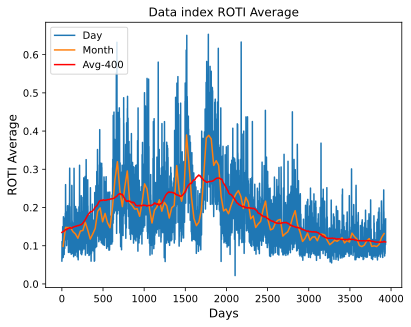

In [7]:
def plot_roti_graph(roti_maps_reshape, roti_map_date):
    average_roti = []
    for i in range(len(roti_maps_reshape)):
        avg = statistics.mean(roti_maps_reshape[i])
        average_roti.append(avg)

    average_roti = np.array(average_roti)
    plot_data_index(roti_map_date, average_roti, 'ROTI Average')

plot_roti_graph(roti_maps_reshape, roti_map_date)

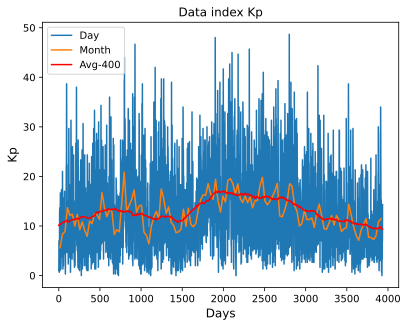

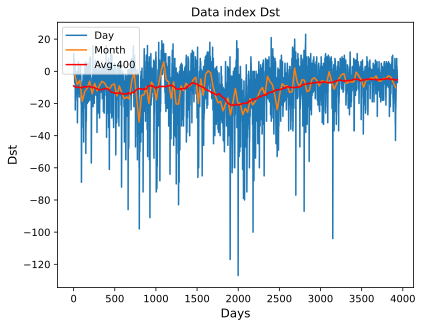

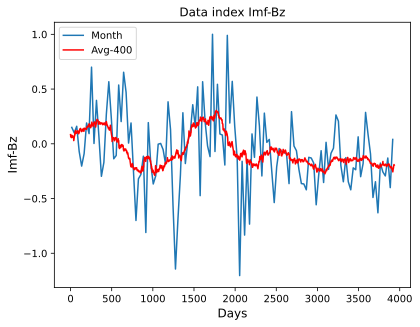

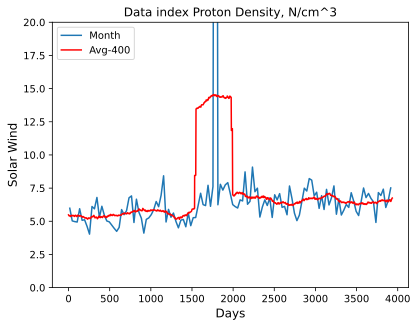

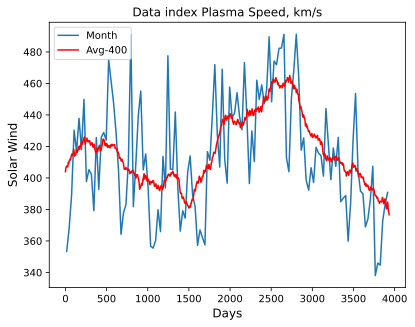

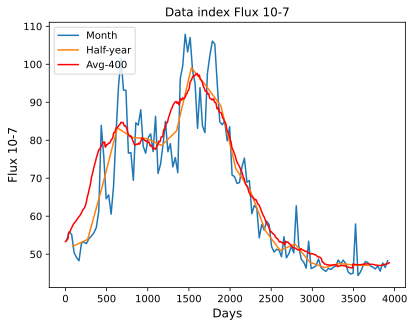

In [8]:
# analyze graphs

plot_data_index(kp_date, kp_arr, 'Kp')
plot_data_index(dst_date, dst_mean_arr, 'Dst')
plot_data_index(bz_date, bz_arr, 'Imf-Bz')
plot_sw_index(sw_date, sw_arr, 'Solar Wind')
# plot_f107_index(f107_date, f107_arr, 'Flux 10-7')
plot_data_index(f107_date, f107_arr, 'Flux 10-7')

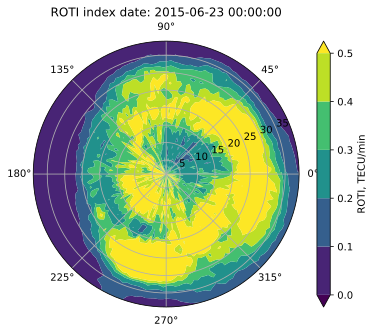

1999


In [9]:
# example of ROTI map

# doy = ["020", "021", "022", "023", "024"]
doy = ["174"]
all_maps = []

for day in doy:
    filename = '../data/roti/2010-2020/roti' + day + '0.15f'

    lats = []
    rows = []
    date_map = []

    date, lats, date_map, map = read_roti(filename)

    all_maps.append(map)
    all_map = np.mean(all_maps, axis=0)
    # print("all_map:\n", all_map.shape[1])
    lons = np.linspace(1, 361, all_map.shape[1])
    # lons = np.linspace(1, 361, 180)
    plot_data_roti(date, lons, lats, map)

for i in range(len(roti_map_date)):
    if roti_map_date[i][0] == 23 and roti_map_date[i][1] == 6 and roti_map_date[i][2] == 2015:
        print(i)
        break



В каждой карте ROTI 3600 вещественных чисел. Нейронной сети сложно предсказать сразу все числа, имея только 29 параметров. Сократим эти данные, взяв среднее по фиксированному числу элементов в каждом массиве.

In [10]:
def roti_encode(roti_maps, less_num):
    new_roti_maps = []
    for i in range(len(roti_maps)):
        j = 0
        new_roti_map = []
        while j < len(roti_maps[i]):
            numbers_roti = []
            for item in range(less_num):
                numbers_roti.append(roti_maps[i][j + item])
            j += less_num
            numbers_roti = np.array(numbers_roti)
            new_roti_map.append(np.mean(numbers_roti))
        new_roti_maps.append(new_roti_map)
    return np.array(new_roti_maps)

def roti_decode(roti_maps, less_num):
    new_roti_maps = []
    for i in range(len(roti_maps)):
        j = 0
        new_roti_map = []
        while j < len(roti_maps[i]):
            for num in range(less_num):
                new_roti_map.append(roti_maps[i][j])
            j += 1
        new_roti_maps.append(new_roti_map)
    return np.array(new_roti_maps)

new_roti_maps = roti_encode(roti_maps_reshape, 5)
new_roti_maps.shape

(3935, 720)

Всего данных - 3935. Будем использовать 92% данных для тренировки сети, 4% для валидации и оставшиеся 4% для теста:
```
- train_data - 3635
- val_data - 150
- test_data - 150
```

Также необходимо провести нормировку всех данных, кроме карт ROTI, поскольку они уже изначально имеют значения в диапазоне (0;1)

In [11]:
# Normalize data
train_num = 3635

def mean_data(data):
    mean = data[:train_num].mean(axis=0)
    data -= mean
    std = data[:train_num].std(axis=0)
    data /= std
    return data

kp_data = mean_data(kp_arr)
bz_data = mean_data(bz_arr)
f107_data = mean_data(f107_arr)
dst_data = mean_data(dst_arr)
sw_data = mean_data(sw_arr)

Соберем данные индексов в единый массив со следующей индексацией:
- 0 : KP index
- 1 : BZ index
- 2 : SW Proton Density
- 3 : SW Plasma Speed
- 4 : F10-7
- 5-28 : DST index

In [12]:
def accumulate_indexes(kp_data, bz_data, sw_data, f107_data, dst_data):
    all_indexes = []
    for i in range(len(kp_data)):
        indexes = []
        # indexes.append(kp_data[i][0])
        indexes.append(bz_data[i][0])
        # indexes.append(sw_data[i][0])
        # indexes.append(sw_data[i][1])
        indexes.append(f107_data[i][0])
        # for j in range(24):
        #     indexes.append(dst_data[i][j])
        all_indexes.append(indexes)
    return np.array(all_indexes)

all_indexes = []
all_indexes = accumulate_indexes(kp_data, bz_data, sw_data, f107_data, dst_data)
all_indexes.shape

(3935, 2)

In [14]:
# for day in doy:
#     filename = '../data/roti/2010-2020/roti' + day + '0.15f'

#     lats = []
#     rows = []
#     date_map = []

#     date, lats, date_map, map = read_roti(filename)

#     all_maps.append(map)
#     all_map = np.mean(all_maps, axis=0)
#     # print("all_map:\n", all_map.shape[1])
#     lons = np.linspace(1, 361, all_map.shape[1])
#     # lons = np.linspace(1, 361, 180)
#     plot_data_roti(date, lons, lats, map)
#     map_data = []
#     for i in range(len(new_roti_maps[1999])):
#         map_data.append(new_roti_maps[1999][i])
#     map_data = np.array(map_data)
#     map_data = map_data.reshape(1, 720)
#     map = roti_decode(map_data, less_num=5)
#     map = map.reshape(20, 180)
#     plot_data_roti(date, lons, lats, map)

- 3935 данных не достаточно для успешной тренировки, поэтому увеличим данные за счет добавки шума к индексам, а целевые данные карт оставим для этих данных такой же. Так мы увеличим *dataset* и улучшим стабильность нейросети. Увелим набор данных в 3 раза, то есть теперь данных будет 11805

- Из 11805 данных 80% выделим для train, а по 10% на val и test:
```
train - 9445
val - 1180
test - 1180
```

In [13]:
# Define class to add andom noise for data (Ornstein–Uhlenbeck process)

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.0015, dt=1e-4, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_init = x_initial
        self.reset()
    
    def __call__(self):
        # Formula is taken from https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process
        x = (
            self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev + np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x

    def reset(self):
        if self.x_init is not None:
            self.x_prev = self.x_init
        else:
            self.x_prev = np.zeros_like(self.mean)

In [14]:
# function for increasing trainig data

std_dev = 0.001
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
# noise = ou_noise()
# print(noise)

def increse_data(new_roti_maps, all_indexes):
    big_indexes = []
    big_roti = []
    for i in range(len(all_indexes)):
        noise_arr = []
        for j in range(len(all_indexes[i])):
            noise = float(ou_noise())
            noise_arr.append(noise)
        noise = np.array(noise_arr)
        big_indexes.append(all_indexes[i] - noise)
        big_roti.append(new_roti_maps[i])
        big_indexes.append(all_indexes[i])
        big_roti.append(new_roti_maps[i])
        big_indexes.append(all_indexes[i] + noise)
        big_roti.append(new_roti_maps[i])
    return np.array(big_indexes), np.array(big_roti)

big_indexes, big_roti = increse_data(new_roti_maps, all_indexes)

print(big_roti.shape)
print(big_indexes.shape)

(11805, 720)
(11805, 2)


Для упрощения целевых значений, сделаем "срез" в данных карт ROTI - если величина в карте > 0.6, то мы приравнивам ее к 0.7

In [17]:
# def change_roti(big_roti):
#     for i in range(len(big_roti)):
#         for j in range(len(big_roti[i])):
#             if big_roti[i][j] > 0.6:
#                 big_roti[i][j] = 0.7
#     return big_roti

# big_roti = change_roti(big_roti)
# big_roti

##### Generation sample-targets lists function
- **data_indexes** — исходный массив вещественных чисел - *all_indexes*
- **roti_data** - преобразованный массив карт ROTI, который будет исполльзоваться в качестве целевых данных - *roti_maps_reshape*
- **lookback** — количество интервалов в прошлом от заданного момента, за которое отбираются входные данные - 5 дней
- **delay** — количество интервалов в будущем от заданного момента, за которое отбираются целевые данные - 1 день. Данный параметр применяется к картам ROTI
- **min_index** и **max_index** — индексы в массиве data, ограничивающие область для извлечения данных; это помогает оставить в неприкосновенности сегменты проверочных и контрольных данных
- **shuffle** — флаг, определяющий порядок извлечения образцов: с перемешиванием или в хронологическом порядке
- **batch_size** — количество образцов в пакете - 32
- **step** — период в интервалах, из которого извлекается один образец - 1

In [15]:
# Generation sample-targets lists function

def generator(data_indexes, roti_data, lookback, delay, min_index, max_index, shuffle=False, batch_size=32, step=1):
    if max_index is None:
        max_index = len(data_indexes) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data_indexes.shape[-1]))
        targets = np.zeros((len(rows), len(roti_data[0])))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data_indexes[indices]
            for item in range(len(roti_data[0])):
                targets[j][item] = roti_data[rows[j] + delay][item]
        # targets = roti_data[i + delay]
        # targets = targets.reshape(20, 180)
        yield samples, targets

# min_index = 0
# lookback = 0
# max_index = 5
# batch_size = 1
# delay = 1
# step = 1

# rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
# samples = np.zeros((len(rows), lookback // step, kp_data.shape[-1]))
# targets = np.zeros((len(rows), len(new_roti_maps[0])))
# for j, row in enumerate(rows):
#     indices = range(rows[j] - lookback, rows[j], step)
#     samples[j] = kp_data[indices]
#     for item in range(len(new_roti_maps[0])):
#         targets[j][item] = new_roti_maps[rows[j] + delay][item]
#     print(new_roti_maps[rows[j] + delay].shape)
# targets.shape

In [16]:
lookback = 6
step = 1
delay = 1
batch_size = 64

# all_indexes = big_indexes
# new_roti_maps = big_roti

all_data_num = all_indexes.shape[0]
min_index_train = 0
max_index_train = int(all_data_num * 0.8)
min_index_val = int(max_index_train + 1)
max_index_val = int(max_index_train + int(all_data_num * 0.1))
min_index_test = int(max_index_val + 1)
max_index_test = None


train_gen = generator(big_indexes,
 big_roti,
 lookback=lookback,
 delay=delay,
 min_index=min_index_train,
 max_index=max_index_train,
 shuffle=True,
 step=step,
 batch_size=batch_size)
val_gen = generator(big_indexes,
 big_roti,
 lookback=lookback,
 delay=delay,
 min_index=min_index_val,
 max_index=max_index_val,
 step=step,
 batch_size=batch_size)
test_gen = generator(big_indexes,
 big_roti,
 lookback=lookback,
 delay=delay,
 min_index=min_index_test,
 max_index=max_index_test,
 step=step,
 batch_size=batch_size)

# Сколько раз нужно обратиться к val_gen, чтобы получить проверочный набор данных целиком
val_steps = (max_index_val - min_index_val - lookback) // batch_size

# Сколько раз нужно обратиться к test_gen gen, чтобы получить контрольный набор данных целиком
test_steps = (len(all_indexes) - min_index_test - lookback) // batch_size


In [17]:
from keras.models import Sequential, model_from_json
from keras import layers
from keras.optimizers import RMSprop, Adam
from keras import regularizers
from keras.callbacks import ModelCheckpoint

In [18]:

weights_file = 'W_LSTM_LSTM_test_1.h5'

callback = ModelCheckpoint(weights_file, mode='max', save_best_only=True)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=2000,
    decay_rate=0.65)

model = Sequential()
model.add(layers.LSTM(256,
 dropout=0.1,
 recurrent_dropout=0.3,
 kernel_regularizer=regularizers.L1(1e-4),
 return_sequences=True,
 input_shape=(None, big_indexes.shape[-1])))
# model.add(layers.LSTM(128,
#  dropout=0.2,
#  recurrent_dropout=0.4,
#  kernel_regularizer=regularizers.L1(0.001),
#  return_sequences=True,))
model.add(layers.LSTM(512,
 dropout=0.2,
 recurrent_dropout=0.4,
 kernel_regularizer=regularizers.L1(0.001),))
# model.add(layers.Dense(500, kernel_regularizer=regularizers.L1(l1=0.005), activation='softmax'))
# model.add(layers.Dense(500, kernel_regularizer=regularizers.L1(l1=0.005), activation='relu'))
# model.add(layers.Dense(1500, kernel_regularizer=regularizers.L1(l1=0.01), activation='relu'))
model.add(layers.Dense(720))
model.summary()
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='mse')

# with open("model.json", 'r') as f:
#     model = model_from_json(f.read)

# model.load_weights('W_LSTM_LSTM_dc_12.h5')

history = model.fit_generator(train_gen,
 steps_per_epoch=200,
 epochs=5,
 validation_data=val_gen,
 validation_steps=val_steps,
 callbacks=[callback])

json_file = 'M_LSTM_LSTM_test_01.json'
model_json = model.to_json()
with open(json_file, 'w') as f:
    f.write(model_json)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 256)         265216    
                                                                 
 lstm_1 (LSTM)               (None, 512)               1574912   
                                                                 
 dense (Dense)               (None, 720)               369360    
                                                                 
Total params: 2,209,488
Trainable params: 2,209,488
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5


2022-11-23 01:09:52.080518: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


200/200 [==============================] - 16s 69ms/step - loss: 1.0148 - val_loss: 0.6250
Epoch 2/5
200/200 [==============================] - 15s 76ms/step - loss: 0.6018 - val_loss: 0.6046
Epoch 3/5
200/200 [==============================] - 15s 75ms/step - loss: 0.5694 - val_loss: 0.5659
Epoch 4/5
200/200 [==============================] - 15s 75ms/step - loss: 0.5401 - val_loss: 0.5299
Epoch 5/5
200/200 [==============================] - 15s 75ms/step - loss: 0.5152 - val_loss: 0.5200


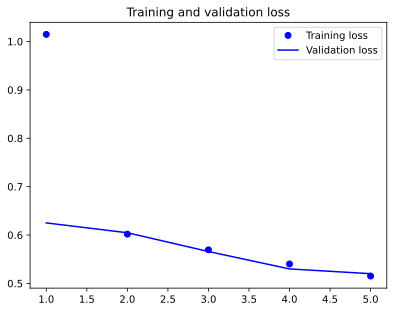

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.ylim(0, 0.3)
plt.legend()
plt.show()

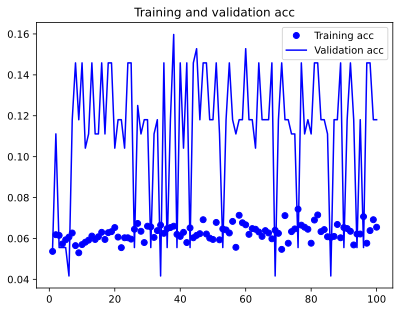

In [31]:
# loss = history.history['acc']
# val_loss = history.history['val_acc']
# epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'bo', label='Training acc')
# plt.plot(epochs, val_loss, 'b', label='Validation acc')
# plt.title('Training and validation acc')
# plt.legend()
# plt.show()

In [20]:
print("Evaluate on test data")
results = model.evaluate_generator(test_gen, steps=test_steps)
print("test loss, test acc:", results)

Evaluate on test data
test loss, test acc: 0.5195558667182922


1/1 [==============================] - 0s 247ms/step
predictions shape: (1, 720)


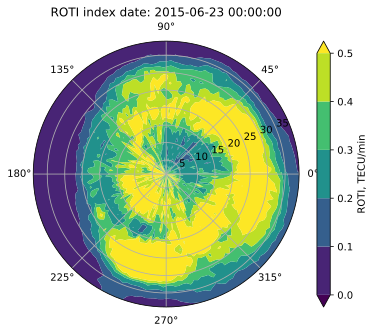

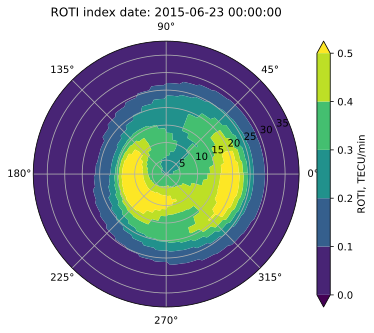

In [21]:
predict = generator(all_indexes,
 new_roti_maps,
 lookback=6,
 delay=1,
 min_index=1992,
 max_index=1999,
 step=1,
 batch_size=1)

predictions = model.predict(predict, steps=1)
print("predictions shape:", predictions.shape)
# print("predictions:", predictions)
doy = ["174"]
for day in doy:
    filename = '../data/roti/2010-2020/roti' + day + '0.15f'

    lats = []
    rows = []
    date_map = []
    all_maps = []

    date, lats, date_map, map = read_roti(filename)

    all_maps.append(map)
    all_map = np.mean(all_maps, axis=0)
    # print("all_map:\n", all_map.shape[1])
    lons = np.linspace(1, 361, all_map.shape[1])
    # lons = np.linspace(1, 361, 180)
    plot_data_roti(date, lons, lats, map)
    map = roti_decode(predictions, less_num=5)
    map = map.reshape(20, 180)
    plot_data_roti(date, lons, lats, map)

1/1 [==============================] - 0s 24ms/step
predictions shape: (1, 720)


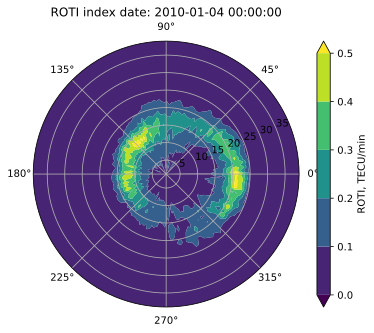

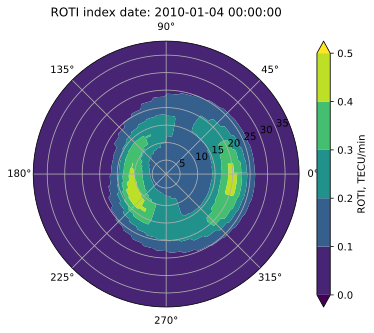

In [22]:
predict = generator(all_indexes,
 new_roti_maps,
 lookback=6,
 delay=1,
 min_index=0,
 max_index=7,
 step=1,
 batch_size=1)

predictions = model.predict(predict, steps=1)
print("predictions shape:", predictions.shape)
# print("predictions:", predictions)
doy = ["004"]
for day in doy:
    filename = '../data/roti/2010-2020/roti' + day + '0.10f'

    lats = []
    rows = []
    date_map = []
    all_maps = []

    date, lats, date_map, map = read_roti(filename)

    all_maps.append(map)
    all_map = np.mean(all_maps, axis=0)
    # print("all_map:\n", all_map.shape[1])
    lons = np.linspace(1, 361, all_map.shape[1])
    # lons = np.linspace(1, 361, 180)
    plot_data_roti(date, lons, lats, map)
    map = roti_decode(predictions, less_num=5)
    map = map.reshape(20, 180)
    plot_data_roti(date, lons, lats, map)

1/1 [==============================] - 0s 25ms/step
predictions shape: (1, 720)


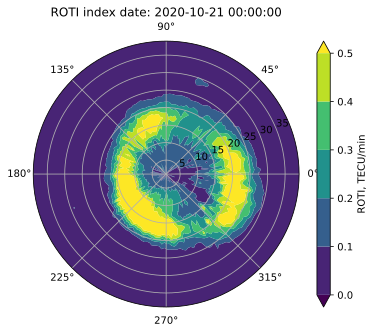

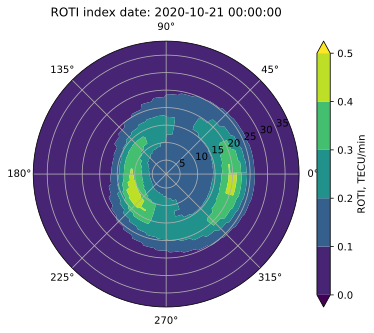

In [23]:
predict = generator(all_indexes,
 new_roti_maps,
 lookback=6,
 delay=1,
 min_index=3925,
 max_index=3934,
 step=1,
 batch_size=1)

predictions = model.predict(predict, steps=1)
print("predictions shape:", predictions.shape)
# print("predictions:", predictions)
doy = ["295"]
for day in doy:
    filename = '../data/roti/2010-2020/roti' + day + '0.20f'

    lats = []
    rows = []
    date_map = []
    all_maps = []

    date, lats, date_map, map = read_roti(filename)

    all_maps.append(map)
    all_map = np.mean(all_maps, axis=0)
    # print("all_map:\n", all_map.shape[1])
    lons = np.linspace(1, 361, all_map.shape[1])
    # lons = np.linspace(1, 361, 180)
    plot_data_roti(date, lons, lats, map)
    map = roti_decode(predictions, less_num=5)
    map = map.reshape(20, 180)
    plot_data_roti(date, lons, lats, map)

## Задачи
- Обновить файл карт + создать для считывания массивов
- Слишком много данных с низким индексом и мало с высоким => переобучение на малые индексы => модель усредняет предсказания
- Добавить lookback на 27 дней назад (то есть 2-3 дня + 1 день 27 дней назад)
- Добавить в данные также предыдущую карту ROTI
- min по imf-bz в день помимо среднесуточных
- 27 дневная медиана для f107
- добавить AE, AU, AL, AO (независимые - AU, AL; производные - AE, AO)
- тест на разных архитектурах
- кроссзависимую таблицу по индексам (корреляция по индексам)